# Base de classification en Anglais 

    - Transformers : Summarization : 2 modèles --> 2 Résumés / Puis score de similarités de ces 2 résumés
    Noter que l'on peut faire aussi la similarité des textes (autre note ?) et non du résumé
    - Text classification sur une base de catégories "Presse" : sport - actaulités - économie - etc
    - Sentiment analysis : voir si le ton du texte est de même type 
    - Les 2 derniers classifier seronts utilisés en produit scalaire : Par Catégorie : texte1: note1 - texte2 : note2
    et donc sum(notes_par_catégorie) = sum(note1*note2) * 100 au bout (note sur 100)

In [1]:
import pandas as pd
import pke
import spacy
import torch
import stanza
import spacy_stanza
import warnings
import string
from gensim.models import KeyedVectors
import enchant    # Pour correction orthographique de synonymes
import numpy as np
import re
from transformers import pipeline
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelWithLMHead, AutoTokenizer
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
tqdm.pandas()
warnings.filterwarnings("ignore")

C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\stg-sdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


**Selection des modèles NLP : ici FRANCAIS**

In [2]:
# Chargement pour l'utilisation de Spacy  - Français
nlp_en = spacy.load("en_core_web_sm")

In [3]:
dico_spacy = {'en':nlp_en}   # 'en':nlp_en,'de':nlp_de,'es':nlp_es,'pl':nlp_pl  - POUR MEMOIRE
langues = ['en','fr','es','de','pl','ar','tr']

In [4]:
# Chargement du modèle Word2Vec pour utilisation de synonymes
import gensim.downloader
model_gensim = gensim.downloader.load('glove-twitter-25')

In [5]:
# Stopwords Français NLTK + Spacy 
stopWords = list(nlp_en.Defaults.stop_words)
stopwords_en = list(stopwords.words('english'))  
stopwords_en = list(set(stopwords_en + stopWords))
stopwds_lg = {'en':stopwords_en}

In [6]:
# correcteur orthographique pour validation des synonymes OPTIONNEL CAR NON NECESSAIRE
d = enchant.Dict("en") 

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Sélection des modèles Transformers : Summary - Text Classification - Sentiment Analysis - Similarity**<br/>
    Pour le modèle anglais, on prend 3 summarizer !!!

In [8]:
# Modèles Transformers de Résumé (NB : Ne pas oublier d'ajouter la truncation pour tous les modèles, peut être source d'erreur)
# Visiblement le modèle google/bigbird-pegasus-large-arxiv est trop gros et le pegasus multi news : les 2 très longs ! et résumé long
# summarizer1 = pipeline("summarization", model="google/bigbird-pegasus-large-arxiv", truncation = "only_first")  # base trop large et longue
# summarizer1 = pipeline("summarization", model="google/pegasus-multi_news", truncation = "only_first")
summarizer1 = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", truncation = "only_first")   # ou sshleifer/distilbart-xsum-12-3
summarizer2 = pipeline("summarization", model="google/pegasus-xsum", truncation = "only_first")  # voir cnn 12-6

In [9]:
# Textes classification ou Zero shot classification (permet de chosir nos propres thèmes)
text_clf1 = pipeline("zero-shot-classification", model = "joeddav/bart-large-mnli-yahoo-answers", truncation = "only_first")   # 10 actégories, voir hugging face
text_clf2 = pipeline('zero-shot-classification', model='cross-encoder/nli-MiniLM2-L6-H768',truncation = "only_first")
# ces modèles sont zero shot classification : catégories possibles choisies par mes soins (dans la presse)
candidate_labels = ['Science', 'Politics', 'Education', 'News', 'Health', 'Technology', 'Society', 'Sport', 'Economy', 'Culture', 'International', 'Environment']

In [10]:
# Sentiment Analysis : base de 1 à 5 stars
sentiment1 = pipeline("text-classification", model = 'nlptown/bert-base-multilingual-uncased-sentiment',truncation = "only_first")

# Sur la base des sentiments classiques : joy, anger, suprise, sadness, love, fear
sentiment2 = pipeline("text-classification", model = 'bhadresh-savani/distilbert-base-uncased-emotion',truncation = "only_first")

# Sur la base des sentiments classiques : NEGATIVE / POSITIVE
sentiment3 = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english',truncation = "only_first")

In [11]:
# ENCODAGE AVEC SENTENCE TRANSFORMER 2 modfèles et moyenne
from sentence_transformers import SentenceTransformer,util
encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
encoder2 = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
def score_similarite(sentence1,sentence2):
    # attention, pour que torch fonctionne en dimension sentence1 (et 2) est une liste simple
    embed1 = encoder.encode(sentence1, convert_to_tensor=True)
    embed2 = encoder.encode(sentence2, convert_to_tensor=True)
    embed3 = encoder2.encode(sentence1, convert_to_tensor=True)
    embed4 = encoder2.encode(sentence2, convert_to_tensor=True)
    return round(float(util.pytorch_cos_sim(embed1,embed2))+float(util.pytorch_cos_sim(embed3,embed4))*100/2,2)

**Selection Data par langues**

In [12]:
data = pd.read_csv('train_data_prep_v1.csv')

In [13]:
data

,pair_id,pair_lang,source_url_1,publish_date_1,source_url_2,publish_date_2,title_1,text_1,meta_description_1,meta_keywords_1,...,text_2,meta_description_2,meta_keywords_2,Geography,Entities,Time,Narrative,Overall,Style,Tone
0,1484084337_1484110209,en_en,https://www.washingtonpost.com,Wed Jan 1 00:00:00 2020,https://www.washingtonpost.com,Wed Jan 1 00:00:00 2020,Virginia man arrested in fatal DUI crash in We...,"MARTINSBURG, W.Va. — A suspected drunken drive...",Police in West Virginia say a suspected drunke...,"['Highway Fatal-DUI-West Virginia', 'Martinsbu...",...,"PORT-AU-PRINCE, Haiti — Haitian President Jove...",Haitian President Jovenel Moïse has broken wit...,"['CB-Haiti-Political Turmoil', 'Jean', 'Haiti'...",4.0,4.000000,1.000000,4.000000,4.000000,1.666667,2.000000
1,1484396422_1483924666,en_en,https://www.stlucianewsonline.com,Wed Jan 1 21:17:15 2020,https://www.thestar.com,Wed Jan 1 00:00:00 2020,Guyana: Three injured after car crashes into u...,Share This On:\n\nPin 11 Shares\n\n(NEWS ROOM ...,-,[''],...,BERLIN - A fire at a zoo in western Germany in...,BERLIN - A fire at a zoo in western Germany in...,"['smg2_world', 'smg_europe', 'smg2_news']",4.0,4.000000,1.000000,4.000000,3.666667,1.666667,1.333333
2,1484698254_1483758694,en_en,https://www.teaparty.org,NaN,https://www.timesofisrael.com,NaN,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,(Breitbart) – President Donald Trump welcomed ...,NaN,[''],...,"PALM BEACH, United States — US President Donal...",US president says response to rioting by pro-I...,[''],1.0,2.000000,1.000000,2.333333,2.333333,1.000000,1.333333
3,1576314516_1576455088,en_en,https://gadgets.ndtv.com,NaN,https://gadgets.ndtv.com,NaN,Zomato Buys Uber's Food Delivery Business in I...,Uber has sold its online food-ordering busines...,Zomato on Tuesday announced it has acquired Ub...,['zomato uber eats business acquisition india ...,...,Rapid digitisation and growth in both online b...,The report by Google and Boston Consulting Gro...,['indian online food delivery market to hit us...,1.0,2.333333,2.666667,1.666667,2.000000,1.666667,1.666667
4,1484036253_1483894099,en_en,https://news.yahoo.com,Wed Jan 1 08:57:59 2020,https://www.channelnewsasia.com,NaN,"India approves third moon mission, months afte...",BENGALURU (Reuters) - India has approved its t...,India has approved its third lunar mission mon...,[''],...,BANGALORE: India plans to make a fresh attempt...,India plans to make a fresh attempt to land an...,"['India', 'space']",1.0,1.250000,1.000000,1.250000,1.250000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959,1586195445_1598778991,tr_tr,http://www.haberler.com,NaN,https://www.haberler.com,NaN,"BM, Aden'de 2 bini aşkın iç göçmenin selden za...","BM, Aden'de 2 bini aşkın iç göçmenin selden za...","Birleşmiş Milletler (BM), 2 bini aşkın iç göçm...","['Birleşmiş Milletler', 'Twitter', 'Yemen', 'G...",...,BM'den Yemen'de kadınların doğumda ölüm riski ...,BİRLEŞMİŞ Birleşmiş Milletler (BM) dünyanın en...,"['Birleşmiş Milletler', 'Yemen', 'Güncel', 'Ha...",1.0,2.000000,2.000000,4.000000,3.000000,1.000000,1.000000
4960,1590915424_1590940388,tr_tr,https://www.haberler.com,NaN,https://www.aksam.com.tr,NaN,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Kovid-19'dan dolayı La Liga kulüplerinde hayat...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,"['Real Madrid', 'İspanya', 'La Liga', 'Futbol'...",...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,Yeni tip koronavirüs (Kovid-19) salgınının eko...,"['İspanya 1. Futbol Ligi', 'la liga', 'koronav...",1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4961,1526157103_1492737005,tr_tr,http://www.samanyoluhaber.com,Thu Feb 20 10:47:10 2020,https://www.fotomac.com.tr,Sun Jan 12 00:00:00 2020,Saray da çare olmadı: 'Borca boğulan dev kulüp...,\n\n\n\n\n\n\n\nİflas noktasındaki kulüplerin ...,SARAY DA ÇARE OLMADI: 'BORCA BOĞULAN DEV KULÜP...,"['Saray', 'da', 'çare', 'olmadı:', ""'Borca""

In [14]:
# remémorer numéro de ligne - compléter les Nan
data['ligne'] = data.index
data = data.fillna('')

In [15]:
# séparation des datasets, le dernier étant à traduire en plus
anglais = data.loc[data.pair_lang == 'en_en',['ligne','title_1','title_2','text_1','text_2','Geography', 'Entities',
       'Time', 'Narrative', 'Overall', 'Style', 'Tone']].reset_index(drop=True)

In [22]:
# Ajouter aussi le modèle anglais_all_traduit 
anglais_all_traduit = pd.read_csv('allemand_anglais_traduit.csv',index_col=0)

**Tests divers et Fonctions nécessaires**

In [17]:
# Résumés
print(summarizer1(anglais.text_1[3])[0]['summary_text'])
print(summarizer1(anglais.text_2[3])[0]['summary_text'])

 Uber has sold its online food-ordering business in India to local rival Zomato in exchange for a 9.99 percent stake in the startup backed by China's Ant Financial . Uber Eats in India accounted for 3 percent of the business' gross bookings globally, but more than a quarter of its adjusted EBITDA loss in first three quarters of 2019 .
 India's online food industry to become an $8 billion (roughly Rs. 56,000) market by 2022 -- growing at a CAGR of 25-30 percent . Zomato and Swiggy currently dominate the online food delivery market in India . Peer or network advocacy played a critical role in drawing people to try online food ordering for the first time .


In [18]:
print(summarizer2(anglais.text_1[3])[0]['summary_text'])
print(summarizer2(anglais.text_2[3])[0]['summary_text'])

It's food for thought for Uber.
"Ordering food online is now a habit."


In [17]:
# Fonction de calcul du score (produit scalaire) pour résultats de classifaction
def fonction_produit_dotcom(liste_categor, dico_scores1,dico_scores2):
    """"dico scores sont les résultats obtenus pour chaque catégorie des textes 1 et 2"""
    result = 0.0
    for cat in liste_categor:
        result += round(dico_scores1[cat] * dico_scores2[cat],4)
    return result * 100

In [18]:
# transformation des résultats du transformer type1
def transform_text_clf1(liste_dico):
    res = {}
    for dic in liste_dico:
        res[dic['label']] = dic['score']
    return res

In [19]:
# transformation des résultats du transformer type2
def transform_text_clf2(liste_cat,liste_sc):
    res = {}
    for i in range(len(liste_cat)):
        res[liste_cat[i]] = liste_sc[i]
    return res

In [22]:
# Tests
classes = text_clf1(anglais.text_1[3], candidate_labels)
scores1 = transform_text_clf2(classes['labels'],classes['scores'])
classes2 = text_clf1(anglais.text_2[3], candidate_labels)
scores2 = transform_text_clf2(classes2['labels'],classes2['scores'])
print(fonction_produit_dotcom(candidate_labels, scores1,scores2))

17.609999999999996


In [23]:
# Tests
classes = text_clf2(anglais.text_1[3], candidate_labels)
scores1 = transform_text_clf2(classes['labels'],classes['scores'])
classes2 = text_clf2(anglais.text_2[3], candidate_labels)
scores2 = transform_text_clf2(classes2['labels'],classes2['scores'])
print(fonction_produit_dotcom(candidate_labels, scores1,scores2))

8.33


In [24]:
# Tests sentiment analysis
liste_labels = ['1 star','2 stars','3 stars','4 stars','5 stars']
# scores1 = transform_text_clf1(sentiment1(anglais.text_1[3],return_all_scores=True)[0])
# scores2 = transform_text_clf1(sentiment1(anglais.text_2[3],return_all_scores=True)[0])
# print(scores1)
# print(scores2)
# print(fonction_produit_dotcom(liste_labels, scores1,scores2))

In [25]:
# ATTENTION CE MODELE SE DEFINIT SUR 4 CLASSES : mixed, positif, negatif, objectif
liste_sentiments = ['joy','anger','sadness','love','surprise','fear']
# scores1 = transform_text_clf1(sentiment2(anglais.title_1[3],return_all_scores=True)[0])
# scores2 = transform_text_clf1(sentiment2(anglais.title_2[3],return_all_scores=True)[0])
# scores3 = transform_text_clf1(sentiment2(anglais.text_1[3],return_all_scores=True)[0])
# scores4 = transform_text_clf1(sentiment2(anglais.text_2[3],return_all_scores=True)[0])
# print(fonction_produit_dotcom(liste_sentiments, scores1,scores2))
# print(fonction_produit_dotcom(liste_sentiments, scores3,scores4))

In [26]:
liste_sentiments2 = ['NEGATIVE','POSITIVE']
# scores1 = transform_text_clf1(sentiment3(anglais.text_1[3],return_all_scores=True)[0])
# scores2 = transform_text_clf1(sentiment3(anglais.text_2[3],return_all_scores=True)[0])
# print(scores1)
# print(scores2)
# print(fonction_produit_dotcom(liste_sentiments2, scores1,scores2))

In [27]:
# TESTS SCORES DE SIMILARITES : Titres, Textes complets (attention Truncation ...)
print(score_similarite(anglais.title_1[3],anglais.title_2[3]))
print(score_similarite(anglais.text_1[3],anglais.text_2[3]))
print(score_similarite(summarizer1(anglais.text_1[0])[0]['summary_text'],summarizer1(anglais.text_2[0])[0]['summary_text']))
print(score_similarite(summarizer2(anglais.text_1[0])[0]['summary_text'],summarizer2(anglais.text_2[0])[0]['summary_text']))

24.97
39.28
3.79
51.0


In [28]:
# Essais de synonymies à utiliser pour sorties PKE, termes prinicpaux
syns = model_gensim.most_similar("death", topn=10)
syns

[('child', 0.8979307413101196),
 ('murder', 0.8967654705047607),
 ('killing', 0.8901609182357788),
 ('kills', 0.8862658143043518),
 ('attack', 0.8817499876022339),
 ('victim', 0.8787229657173157),
 ('killed', 0.8760652542114258),
 ('suicide', 0.875905454158783),
 ('dies', 0.8747766613960266),
 ('died', 0.8738439083099365)]

In [20]:
# Fonctions de summarization 
def summarization(texte):
    return summarizer1(texte)[0]['summary_text'], summarizer2(texte)[0]['summary_text']

In [27]:
dico_classifiers = {'text_clf1': 'score_classif1','text_clf2':'score_classif2','sentiment1':'score_sentiment1',
                    'sentiment2': 'score_sentiment2','sentiment3': 'score_sentiment3'}
dico_categories = {'text_clf1': candidate_labels,'text_clf2':candidate_labels,'sentiment1':liste_labels,
                    'sentiment2': liste_sentiments,'sentiment3': liste_sentiments2}

In [28]:
# Fonctions de classification et sentiment analysis
def classification(texte,clf):
    # assume nms des claasifiers et methode de transformation
    if clf == "text_clf1":
        try:
            classes = text_clf1(texte,dico_categories['text_clf1'])
        except:
            return 'error'
        else:
            return transform_text_clf2(classes['labels'],classes['scores'])    
    elif clf == "text_clf2":                                 
        try:
            classes = text_clf2(texte,dico_categories['text_clf2'])
        except:
            return 'error'
        else:
            return transform_text_clf2(classes['labels'],classes['scores'])                          
    elif clf == "sentiment1":
        try:
            scores = transform_text_clf1(sentiment1(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    elif clf == "sentiment2":
        try:
            scores = transform_text_clf1(sentiment2(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    elif clf == "sentiment3":
        try:
            scores = transform_text_clf1(sentiment3(texte,return_all_scores=True)[0])
        except:
            return 'error'
        else:
            return scores
    else:
        return 'error'

In [29]:
# Prétraitement NLP pour PKE : suppression des mots de moins de 2 lettres non numériques
def supp_moins_2_lettres_stopwords(phrase,stopwd):
    temp = phrase.split(' ')
    res = ''
    for mot in temp:
        if mot not in stopwd and (len(mot)>2 or (len(mot)>0 and mot[0] in ['0','1','2','3','4','5','6','7','8','9'])):
            res += mot + ' '
    return res[:-1]

In [30]:
# Prétraitement NLP pour PKE : suppression des traits d'union(regroupe)/ des apostrophes / ponctuations
def modif(texte,stopmots):
    # modifications simples des textes : ponctuations, petits mots, stopwords (à faire pour entités et pke textes)
    texte=re.sub('\'',' ',texte)   # suppression apostrophe
    texte=re.sub('-','',texte)    # suppression trait union
    regex = re.compile('[%s]' % re.escape(string.punctuation)) # suppression de toutes les ponctuations
    texte=regex.sub(' ',texte)
    texte = supp_moins_2_lettres_stopwords(texte,stopmots)
    return texte

In [31]:
# Ajout des synonymes (existants en orthographe) à la suite de l'analyse pke
def ajout_synonymes(mot, correct_ortho = True):
    # on ajoute les 10 premiers synonymes existants, on vérifie orthographe (optionnel)
    syns = model_gensim.most_similar(mot,topn = 20)
    if correct_ortho == True:
        res = []
        for m in syns:
            if d.check(m[0]):   #  il y a le mot et son pourcentage d'importance
                res.append(m)
        syns = res
    return syns[:10]

Quelle est la bonne méthodologie à appliquer PKE ??? : Noms Ok - Verbes ? - Adjectifs ? - Noms propres ?
Quelle quantité de mots prendre ?
Ne pas noter les titres seuls ? : trop peu de mots !  Et du coup note peut être forte avec un seul mot !
Supprimer en en-tête les stopwords, ponctuation, les apostrophes - AUTRES ?????

In [32]:
# Choix des paramètres de la méthode : A revoir ?
methode1 = {"NOUN", "PROPN", "ADJ","VERB"}
methode2 = {"NOUN", "PROPN", "ADJ"}
nb_mots = {'meth1': 30, 'meth2':50}

In [33]:
# PKE : Analyse des termes principaux dans les textes et titres 
# Problème 
def transformation_pke_results(res1,res2, correct_ortho = True):
    """
    Transformation des resultats de PKE : Pb bigramme peuvent ne pas être ds les 2 textes mais 1 mot seulement
    liste de clés et dictionnaires de valeurs, bigrammes jouera ainsi de maniere coefficientée 
    Exemple : fuite eau:0.05 --> 3 mots au final : fuite, eau, fuite eau : 0.05
    De plus on ajoute les synonymes issus de gensim en les coefficiant et vérifiant que cela """
    
    liste1 = []; liste2 = [] ; dico1 = {}; dico2 = {}
    for elt in res1:
        liste1.append(elt[0])
        dico1[elt[0]] = round(elt[1],3)
        if ' ' in elt[0]:    # bigramme dans ce cas, ajout des 2 mots
            liste = elt[0].split(' ')
            for mot in liste:
                liste1.append(mot)
                dico1[mot] = round(elt[1],3)
                try:
                    synonyms = ajout_synonymes(mot,correct_ortho = correct_ortho)
                except:
                    pass
                else:
                    for syn in synonyms:
                        liste1.append(syn[0])   # Ajout du mot 
                        dico1[syn[0]] = round(elt[1] * syn[1], 3)  # poids considéré
                    
    for elt in res2:
        liste2.append(elt[0])
        dico2[elt[0]] = round(elt[1],3)
        if ' ' in elt[0]:
            liste = elt[0].split(' ')
            for mot in liste:
                liste2.append(mot)
                dico2[mot] = round(elt[1],3)
                try:
                    synonyms = ajout_synonymes(mot,correct_ortho = correct_ortho)
                except:
                    pass
                else:
                    for syn in synonyms:
                        liste2.append(syn[0])   # Ajout du mot 
                        dico2[syn[0]] = round(elt[1] * syn[1], 3)  # poids considéré
    
    # similarites entre les 2 listes issus de pke avec poids
    sim = 0
    for elt in liste1:
        if elt in liste2:
            sim += (dico1[elt] + dico2[elt])/2
    return sim

In [54]:
def entites_communes(nlp,text1,text2):
    """"
    Cette première fonction ne regarde que les entités communes : personnes, dates, groupe, localisations
    Elle sera appliquée aux textes et aux titres et cumulé : si cumul en titre et texte : compte double !"""
    
    try:
        doc1 = nlp(text1)
        doc2 = nlp(text2)
    except:
        return (0,[],0,[],0,[])
    else:
        nb_commun_ent = 0; liste_commun_ent = []
        nb_commun_geo = 0; liste_commun_geo = []
        nb_commun_dat = 0; liste_commun_dat = []

        if len(doc1.ents)>0 and len(doc2.ents)>0:
            liste1 = []; dico1 = {}
            for elt in doc1.ents:
                if elt.label_ in ['PERSON','PER'] and ' ' in elt.text:
                    mots = elt.text.split(' ')
                    for mot in mots:
                        if mot not in liste1:
                            liste1.append(mot)
                            dico1[mot] = elt.label_
                elif elt.label_ in ['LOC','ORG','GPE','DATE','TIME']:
                    if elt.text not in liste1:
                        liste1.append(elt.text)
                        dico1[elt.text] = elt.label_
            liste2 = []
            for elt in doc2.ents:
                if elt.label_ in ['PERSON','PER'] and ' ' in elt.text:
                    mots = elt.text.split(' ')
                    for mot in mots:
                        if mot not in liste2:
                            liste2.append(mot)
                elif elt.label_ in ['LOC','ORG','GPE','DATE','TIME']:
                    if elt.text not in liste2:
                        liste2.append(elt.text)

            # points communs des listes        
            for elt in liste1:
                if elt in liste2:
                    if dico1[elt] == 'LOC':
                        nb_commun_geo += 1
                        liste_commun_geo.append(elt)
                    elif dico1[elt] in ['DATE','TIME']:
                        nb_commun_dat += 1
                        liste_commun_dat.append(elt)
                    else:
                        nb_commun_ent += 1
                        liste_commun_ent.append(elt)

        return nb_commun_ent, liste_commun_ent,nb_commun_geo, liste_commun_geo,nb_commun_dat, liste_commun_dat

In [85]:
def Creation_features_comparaison(df,langue, test_position = [methode1,methode2]):
    """Création des notes pour classification ensuite"""
    
    resultats = pd.DataFrame(columns = ['summary1_text1','summary2_text1','summary1_text2','summary2_text2',
            'nb_entites_idem','nb_lieux_idem', 'nb_dates_idem','entites_idem','lieux_idem','dates_idem',
            'score_similarite_titres','score_similarite_resume1','score_similarite_resume2','score_classif1','score_classif2',
            'score_sentiment1','score_sentiment2','score_sentiment3','meth1_similarites','meth2_similarites'])
    
    # initialisation de la langue stanza
    stanza.download(langue)
    nlp_stanza = spacy_stanza.load_pipeline(langue)
    stopmts = stopwds_lg[langue]
    if langue in dico_spacy.keys():
        nlp_spacy = dico_spacy[langue]
    else:
        nlp_spacy = None
        
    for i in tqdm(range(len(df))):
        dico_res = {}
        
        # Summary et comparatifs 
        try:
            dico_res['summary1_text1'],dico_res['summary2_text1'] = summarization(df.text_1[i])
        except:
            dico_res['summary1_text1'] = '';dico_res['summary2_text1'] = ''
        try:
            dico_res['summary1_text2'],dico_res['summary2_text2'] = summarization(df.text_2[i])
        except:
            dico_res['summary1_text2'] = '';dico_res['summary2_text2'] = ''
        try:
            dico_res['score_similarite_titres'] = score_similarite(df.title_1[i],df.title_2[i])
        except:
            dico_res['score_similarite_titres'] = 'Error'
        if len(dico_res['summary1_text1'])>0 and len(dico_res['summary1_text2'])>0:
            dico_res['score_similarite_resume1'] = score_similarite(dico_res['summary1_text1'],dico_res['summary1_text2'])
        else:
            dico_res['score_similarite_resume1'] = 0
        if len(dico_res['summary2_text1'])>0 and len(dico_res['summary2_text2'])>0:
            dico_res['score_similarite_resume2'] = score_similarite(dico_res['summary2_text1'],dico_res['summary2_text2'])
        else:
            dico_res['score_similarite_resume2'] = 0
        
        # analyse de textes classification et de sentiments
        if type(df.title_1[i]) == str and type(df.text_1[i]) == str:
            texte1 = df.title_1[i] + ' ' + df.text_1[i]
        elif type(df.title_1[i]) == str:
            texte1 = df.title_1[i]
        elif type(df.text_1[i]) == str:
            texte1 = df.text_1[i]   
        else:
            texte1=''
        if type(df.title_2[i]) == str and type(df.text_2[i]) == str:
            texte2 = df.title_2[i] + ' ' + df.text_2[i]
        elif type(df.title_2[i]) == str:
            texte2 = df.title_2[i]
        elif type(df.text_2[i]) == str:
            texte2 = df.text_2[i]   
        else:
            texte2=''
        if len(texte1)>0 and len(texte2)>0:
            for classifier in dico_classifiers.keys():
                scores1 = classification(texte1,classifier)
                scores2 = classification(texte2,classifier)
                if scores1 != 'error' and scores2 != 'error':
                    dico_res[dico_classifiers[classifier]] = fonction_produit_dotcom(dico_categories[classifier], scores1,scores2)
                else:
                    scores1 = classification(df.title_1[i],classifier)
                    scores2 = classification(df.title_2[i],classifier)
                    if scores1 != 'error' and scores2 != 'error':
                        dico_res[dico_classifiers[classifier]] = fonction_produit_dotcom(dico_categories[classifier], scores1,scores2)
                    else:
                        dico_res[dico_classifiers[classifier]] = None
        else:
            for classifier in dico_classifiers.keys():
                dico_res[dico_classifiers[classifier]] = 0
                
        # pré traitement des textes pour entités et PKE
        texte1 = modif(texte1, stopmts)
        texte2 = modif(texte2, stopmts)
        
        # ENTITES COMMUNES : on tient compte des bigrammes Noms qui posent erreurs ex: Joe Biden et Biden 
        # Ici, on considère mieux le CUMUl titres et Textes avec une pondération double pour le titre 
        # Il faut aussi enlever les petits mots donc pré-traitement en texte
        
        try:
            nb_ent1,list_ent1,nb_geo1,list_geo1,nb_dat1,list_dat1 = entites_communes(nlp_stanza,df.title_1[i],df.title_2[i])
        except:
            nb_ent1,list_ent1,nb_geo1,list_geo1,nb_dat1,list_dat1 = (0,[],0,[],0,[])
        try:
            nb_ent2,list_ent2,nb_geo2,list_geo2,nb_dat2,list_dat2 = entites_communes(nlp_stanza,df.text_1[i],df.text_2[i])
        except:
            nb_ent2,list_ent2,nb_geo2,list_geo2,nb_dat2,list_dat2 = (0,[],0,[],0,[])                                                                       
        if nlp_spacy != None:
            nb_ent3,list_ent3,nb_geo3,list_geo3,nb_dat3,list_dat3 = entites_communes(nlp_spacy,df.title_1[i],df.title_2[i])
            nb_ent4,list_ent4,nb_geo4,list_geo4,nb_dat4,list_dat4 = entites_communes(nlp_spacy,df.text_1[i],df.text_2[i])
        else:
            nb_ent3,list_ent3,nb_geo3,list_geo3,nb_dat3,list_dat3 = (0,[],0,[],0,[])
            nb_ent4,list_ent4,nb_geo4,list_geo4,nb_dat4,list_dat4 = (0,[],0,[],0,[])
        dico_res['nb_entites_idem'] = nb_ent1 * 2 + nb_ent2 + nb_ent3 * 2 + nb_ent4
        dico_res['nb_lieux_idem'] = nb_geo1  * 2 + nb_geo2 + nb_geo3  * 2 + nb_geo4
        dico_res['nb_dates_idem'] = nb_dat1 * 2 + nb_dat2 + nb_dat3 * 2 + nb_dat4
        # fusion des listes en supprimant les doublons
        dico_res['entites_idem'] = list(set(list_ent1+list_ent2+ list_ent3+list_ent4))
        dico_res['lieux_idem'] = list(set(list_geo1+list_geo2+list_geo3+list_geo4))
        dico_res['dates_idem'] = list(set(list_dat1+list_dat2+list_dat3+list_dat4))
        
        for j,meth in enumerate(test_position):
            nom ='meth'+str(j+1)
            nb_mots_meth = nb_mots[nom]
            if len(texte1)>0 and len(texte2)>0:
                extractor = pke.unsupervised.TopicRank()
                extractor.load_document(input=texte1,language=langue,normalization="stemming")
                extractor.candidate_selection(pos=meth)
                extractor.candidate_weighting()
                keyphrases3 = extractor.get_n_best(n=nb_mots_meth)
                extractor = pke.unsupervised.TopicRank()
                extractor.load_document(input=texte2,language=langue,normalization="stemming")
                extractor.candidate_selection(pos=meth)
                extractor.candidate_weighting()
                keyphrases4 = extractor.get_n_best(n=nb_mots_meth)
                dico_res[nom+'_similarites'] = round(100*transformation_pke_results(keyphrases3,keyphrases4),1)
            else:
                dico_res[nom+'_similarites'] = 'Error'
        
        resultats.loc[len(resultats)] = dico_res
        
    newdf = pd.concat([df,resultats],axis=1)
    return newdf

In [86]:
# Attention, problème de mémoire : faire par steps de 200, voir pb (peut arriver sur certains textes pourris)
# le n°50 n'a pas de sens en texte 2 - nbreux pbs tags : 'GW'
# similarites = Creation_features_comparaison(anglais[350:400].reset_index(drop=True),'en')

In [87]:
# # similarites.to_csv('corpus_en_notes.csv')   # A Utiliser pour le premier
# precedent = pd.read_csv('corpus_en_notes.csv',index_col=0)
# similarites2 = pd.concat([precedent,similarites], axis=0)
# #similarites2 = similarites2.sort_values(by='ligne').reset_index(drop=True)
# similarites2 = similarites2.reset_index(drop=True)
# similarites2.to_csv('corpus_en_notes.csv')

In [88]:
# for j in range(10):
#     similarites = Creation_features_comparaison(anglais[1301+100*j:1301+100*(j+1)].reset_index(drop=True),'en')
#     precedent = pd.read_csv('corpus_en_notes.csv',index_col=0)
#     similarites2 = pd.concat([precedent,similarites], axis=0)
#     similarites2 = similarites2.reset_index(drop=True)
#     similarites2.to_csv('corpus_en_notes.csv')

In [89]:
anglais_all_traduit[19:100]

,ligne,title_1,title_2,text_1,text_2,Geography,Entities,Time,Narrative,Overall,Style,Tone,title_1_de,text_1_de
19,4280,"Germany weather: expert makes ""shock forecast""...","Black Jack Brigade Convoys to Hohenfels, Germa...",Weather experts present a first forecast for t...,"Elements of 2nd Armored Brigade Combat Team, 1...",3.0,4.0,4.0,4.0,4.0,2.0,3.0,Deutschland-Wetter: Experte macht „Schockprogn...,Wetter-Experten stellen eine erste Prognose fü...
20,4281,Currency: Euro sinks to monthly low,“The Wuhan Shake”- Will It Catch On In Spain?,FRANKFURT (dpa-AFX) - The euro exchange rate f...,\n\n\n\n\n\nPeople in Italy have been advised ...,2.0,3.0,3.0,4.0,4.0,3.0,2.0,Devisen: Euro sinkt auf Monatstief,FRANKFURT (dpa-AFX) - Der Eurokurs ist am Donn...
21,4282,"Chris Trousdale, singer of the boy band Dream ...",NaN,Singer of the former Boyband Dream Street Chri...,NaN,1.0,1.0,1.0,2.0,2.0,1.0,1.0,"Chris Trousdale, Sänger der Boyband Dream Stre...",Sänger der ehemaligen Boyband Dream Street Chr...
22,4283,Berlinale tips for March 1st,Coverage of COVID-19 puts journalists at risk ...,Berlinale Tips for the Short-Decided: At this ...,Journalists in Africa are at risk of being det...,4.0,4.0,3.0,4.0,4.0,3.0,3.0,Berlinale-Tipps für den 1. März,Berlinale-Tipps für Kurzentschlossene: Unsere ...
23,4284,Black paramedic shot shot: Beyoncé demands pro...,Beyoncé Makes Surprise Appearance on Disney Si...,Advertisement Advertisement Louisville.US sing...,Image zoom ABC\n\nBeyoncé surprised Disney fan...,2.0,3.0,3.0,4.0,4.0,2.0,3.0,Schwarze Sanitäterin erschossen: Beyoncé verla...,Anzeige\n\nAnzeige\n\nLouisville. Die US-Sänge...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4356,"Child abuse: ""My foster mother sold me for sex",Germany's Merkel backs WHO as calls for more c...,"Getty Images/iStockphoto More than 50.In 2018,...",NaN,4.0,4.0,4.0,4.0,4.0,2.0,3.0,Kindesmisshandlung: „Meine Pflege-Mutter verka...,Getty Images/iStockphoto\n\nMehr als 50.000 Ma...
96,4357,Conte: Italy loosens the Corona restrictions,Covid-19 outbreak will strengthen Italy - Conte,OK We use cookies and other technologies on ou...,Italy's dramatic coronavirus epidemic is an ed...,1.0,1.0,3.0,3.0,2.0,2.0,2.0,Conte: Italien lockert die Corona-Beschränkungen,OK\n\nWir setzen auf unserer Website Cookies u...
97,4358,CDU Secretary of State Krings against clear na...,German coalition parties wrestle over cash inc...,Düsseldorf (ots) - In the debate about hate an...,Article content\n\nBERLIN — Germany’s Social D...,1.0,3.0,4.0,4.0,4.0,1.0,1.0,CDU-Staatssekretär Krings gegen Klarnamen-Pfli...,Düsseldorf (ots) - In der Debatte um Hass und ...
98,4359,Ahrensburg: Casa-Rossa-Wirt gives up and looks...,How to grow chicory | Alys Fowler,Ahrensburg.Only one and a half years after his...,Italians put these bitter greens at the heart ...,3.0,4.0,4.0,4.0,4.0,2.0,2.0,Ahrensburg: Casa-Rossa-Wirt gibt auf und sucht...,Ahrensburg. Nur anderthalb Jahre nach seinem C...


In [90]:
# Attention, problème de mémoire : faire par steps de 200, voir pb (peut arriver sur certains textes pourris)
# bloque à 4, à 17
similarites = Creation_features_comparaison(anglais_all_traduit[:100].reset_index(drop=True),'en')

2021-12-29 19:42:24 INFO: Downloading default packages for language: en (English)...
2021-12-29 19:42:25 INFO: File exists: C:\Users\stg-sdu\stanza_resources\en\default.zip.
2021-12-29 19:42:28 INFO: Finished downloading models and saved to C:\Users\stg-sdu\stanza_resources.
2021-12-29 19:42:28 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2021-12-29 19:42:28 INFO: Use device: cpu
2021-12-29 19:42:28 INFO: Loading: tokenize
2021-12-29 19:42:28 INFO: Loading: pos
2021-12-29 19:42:28 INFO: Loading: lemma
2021-12-29 19:42:28 INFO: Loading: depparse
2021-12-29 19:42:28 INFO: Loading: sentiment
2021-12-29 19:42:28 INFO: Loading: constituency
2021-12-29 19:42:29 INFO: Loading: ner
2021-12-29 19:42:29 INFO: Done loading proces

  0%|          | 0/100 [00:00<?, ?it/s]

Your max_length is set to 142, but you input_length is only 37. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 35. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 134. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 36. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 34. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 90. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 87. You might consider 

In [91]:
similarites.to_csv('corpus_en_de_notes.csv')   # A Utiliser pour le premier
# precedent = pd.read_csv('corpus_en_de_notes.csv',index_col=0)
# similarites2 = pd.concat([precedent,similarites], axis=0)
# similarites2 = similarites2.reset_index(drop=True)
# similarites2.to_csv('corpus_en_de_notes.csv')

In [92]:
# pour vérification concat
# precedent = pd.read_csv('corpus_en_de_notes.csv',index_col=0)
# precedent

In [93]:
for j in range(5):
    similarites = Creation_features_comparaison(anglais[100+100*j:100+100*(j+1)].reset_index(drop=True),'en')
    precedent = pd.read_csv('corpus_en_de_notes.csv',index_col=0)
    similarites2 = pd.concat([precedent,similarites], axis=0)
    similarites2 = similarites2.reset_index(drop=True)
    similarites2.to_csv('corpus_en_de_notes.csv')

2021-12-29 21:44:10 INFO: Downloading default packages for language: en (English)...
2021-12-29 21:44:11 INFO: File exists: C:\Users\stg-sdu\stanza_resources\en\default.zip.
2021-12-29 21:44:14 INFO: Finished downloading models and saved to C:\Users\stg-sdu\stanza_resources.
2021-12-29 21:44:14 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2021-12-29 21:44:14 INFO: Use device: cpu
2021-12-29 21:44:14 INFO: Loading: tokenize
2021-12-29 21:44:14 INFO: Loading: pos
2021-12-29 21:44:14 INFO: Loading: lemma
2021-12-29 21:44:14 INFO: Loading: depparse
2021-12-29 21:44:14 INFO: Loading: sentiment
2021-12-29 21:44:15 INFO: Loading: constituency
2021-12-29 21:44:15 INFO: Loading: ner
2021-12-29 21:44:15 INFO: Done loading proces

  0%|          | 0/100 [00:00<?, ?it/s]

Your min_length is set to 56, but you input_length is only 3. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 121. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your min_length is set to 56, but you input_length is only 3. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 1. You might consider decreasi

2021-12-30 00:23:36 INFO: Downloading default packages for language: en (English)...
2021-12-30 00:23:37 INFO: File exists: C:\Users\stg-sdu\stanza_resources\en\default.zip.
2021-12-30 00:23:40 INFO: Finished downloading models and saved to C:\Users\stg-sdu\stanza_resources.
2021-12-30 00:23:40 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2021-12-30 00:23:40 INFO: Use device: cpu
2021-12-30 00:23:40 INFO: Loading: tokenize
2021-12-30 00:23:40 INFO: Loading: pos
2021-12-30 00:23:40 INFO: Loading: lemma
2021-12-30 00:23:40 INFO: Loading: depparse
2021-12-30 00:23:41 INFO: Loading: sentiment
2021-12-30 00:23:41 INFO: Loading: constituency
2021-12-30 00:23:41 INFO: Loading: ner
2021-12-30 00:23:42 INFO: Done loading proces

  0%|          | 0/100 [00:00<?, ?it/s]

Your min_length is set to 56, but you input_length is only 3. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 118. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your min_length is set to 56, but you input_length is only 3. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 1. You might consider decreasi

Your max_length is set to 142, but you input_length is only 113. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 41. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 38. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 104. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 126. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 34. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 31. You might conside

2021-12-30 02:57:53 INFO: Downloading default packages for language: en (English)...
2021-12-30 02:57:53 INFO: File exists: C:\Users\stg-sdu\stanza_resources\en\default.zip.
2021-12-30 02:57:57 INFO: Finished downloading models and saved to C:\Users\stg-sdu\stanza_resources.
2021-12-30 02:57:57 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2021-12-30 02:57:57 INFO: Use device: cpu
2021-12-30 02:57:57 INFO: Loading: tokenize
2021-12-30 02:57:57 INFO: Loading: pos
2021-12-30 02:57:57 INFO: Loading: lemma
2021-12-30 02:57:57 INFO: Loading: depparse
2021-12-30 02:57:57 INFO: Loading: sentiment
2021-12-30 02:57:57 INFO: Loading: constituency
2021-12-30 02:57:58 INFO: Loading: ner
2021-12-30 02:57:58 INFO: Done loading proces

  0%|          | 0/100 [00:00<?, ?it/s]

Your min_length is set to 56, but you input_length is only 3. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your min_length is set to 56, but you input_length is only 3. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your min_length is set to 56, but you input_length is only 16. You might consider decreasing

Your max_length is set to 142, but you input_length is only 91. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 116. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


2021-12-30 05:43:27 INFO: Downloading default packages for language: en (English)...
2021-12-30 05:43:28 INFO: File exists: C:\Users\stg-sdu\stanza_resources\en\default.zip.
2021-12-30 05:43:31 INFO: Finished downloading models and saved to C:\Users\stg-sdu\stanza_resources.
2021-12-30 05:43:31 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2021-12-30 05:43:31 INFO: Use device: cpu
2021-12-30 05:43:31 INFO: Loading: tokenize
2021-12-30 05:43:31 INFO: Loading: pos
2021-12-30 05:43:31 INFO: Loading: lemma
2021-12-30 05:43:31 INFO: Loading: depparse
2021-12-30 05:43:31 INFO: Loading: sentiment
2021-12-30 05:43:31 INFO: Loading: constituency
2021-12-30 05:43:32 INFO: Loading: ner
2021-12-30 05:43:32 INFO: Done loading proces

  0%|          | 0/100 [00:00<?, ?it/s]

Your min_length is set to 56, but you input_length is only 3. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 1. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 78. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 141. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 128. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 87. You might consider de

2021-12-30 08:40:49 INFO: Downloading default packages for language: en (English)...
2021-12-30 08:40:50 INFO: File exists: C:\Users\stg-sdu\stanza_resources\en\default.zip.
2021-12-30 08:40:54 INFO: Finished downloading models and saved to C:\Users\stg-sdu\stanza_resources.
2021-12-30 08:40:54 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2021-12-30 08:40:54 INFO: Use device: cpu
2021-12-30 08:40:54 INFO: Loading: tokenize
2021-12-30 08:40:54 INFO: Loading: pos
2021-12-30 08:40:54 INFO: Loading: lemma
2021-12-30 08:40:54 INFO: Loading: depparse
2021-12-30 08:40:54 INFO: Loading: sentiment
2021-12-30 08:40:54 INFO: Loading: constituency
2021-12-30 08:40:55 INFO: Loading: ner
2021-12-30 08:40:55 INFO: Done loading proces

  0%|          | 0/100 [00:00<?, ?it/s]

Your max_length is set to 142, but you input_length is only 91. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 118. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 115. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 46. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 64, but you input_length is only 41. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your min_length is set to 56, but you input_length is only 3. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)
Your max_length is set to 142, but you input_length is only 3. You might consider d

## Classification Sklearn Pycaret

In [103]:
anglais = pd.read_csv('corpus_en_notes.csv',index_col=0)
anglais = anglais.reset_index(drop=True)
anglais2 = pd.read_csv('corpus_en_de_notes.csv',index_col=0)
anglais2 = anglais.reset_index(drop=True)
# attention, il faut les memes colonnes
anglais2 = anglais[anglais.columns]
anglais = pd.concat([anglais,anglais2],axis=0).reset_index(drop=True)

In [104]:
# attention certains textes ne sont pas fournies et donc mis en "Error" : A supprimer donc
# On pourrait éventuellement tester en ne prenant plus les meth similarités ds les predicteurs
anglais = anglais[anglais.meth1_similarites!='Error']

In [105]:
anglais

,ligne,title_1,title_2,text_1,text_2,Geography,Entities,Time,Narrative,Overall,...,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,score_sentiment3,meth1_similarites,meth2_similarites
0,0,Virginia man arrested in fatal DUI crash in We...,Haiti’s leader marks independence day amid sec...,"MARTINSBURG, W.Va. — A suspected drunken drive...","PORT-AU-PRINCE, Haiti — Haitian President Jove...",4.0,4.000000,1.000000,4.000000,4.000000,...,0.80,3.79,51.00,10.42,8.33,32.09,13.47,99.20,818.0,231.9
1,1,Guyana: Three injured after car crashes into u...,Fire kills more than 30 animals at zoo in west...,Share This On:\n\nPin 11 Shares\n\n(NEWS ROOM ...,BERLIN - A fire at a zoo in western Germany in...,4.0,4.000000,1.000000,4.000000,3.666667,...,6.44,9.10,2.91,10.57,8.34,28.15,92.87,99.04,129.5,174.9
2,2,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,"Trump says he does not expect war with Iran, ‘...",(Breitbart) – President Donald Trump welcomed ...,"PALM BEACH, United States — US President Donal...",1.0,2.000000,1.000000,2.333333,2.333333,...,20.70,27.45,9.68,13.14,8.33,25.00,2.56,96.75,827.2,504.8
3,3,Zomato Buys Uber's Food Delivery Business in I...,Indian Online Food Delivery Market to Hit $8 B...,Uber has sold its online food-ordering busines...,Rapid digitisation and growth in both online b...,1.0,2.333333,2.666667,1.666667,2.000000,...,24.97,27.90,10.34,18.21,8.35,23.79,93.55,94.72,620.0,735.1
4,4,"India approves third moon mission, months afte...",India targets new moon mission in 2020,BENGALURU (Reuters) - India has approved its t...,BANGALORE: India plans to make a fresh attempt...,1.0,1.250000,1.000000,1.250000,1.250000,...,29.21,32.40,-1.95,15.76,8.35,26.28,74.48,93.05,473.0,559.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591,3444,Migrate or Clone VMs to new vCenter at other site,vCenter Email Alerts not working anymore?,"Hello,\n\nWe are preparing to move our environ...",I'm running vCenter 6.7 w/ three host also run...,4.0,3.000000,1.000000,2.000000,3.000000,...,15.18,0.96,-0.44,52.18,9.54,28.40,97.16,99.92,289.7,418.5
3592,3445,You can now consult with your doctors through ...,Never waste a crisis,You can now consult with your doctors through ...,India is doing a commendable job in fighting t...,1.0,4.000000,3.000000,4.000000,4.000000,...,4.29,14.06,1.64,27.53,8.29,31.73,1.55,13.10,40.4,150.6
3593,3446,Thai soldier who killed 20 is shot dead,Thai soldier shot dead after killing 26 in cou...,Jakraphanth Thomma on Saturday killed his comm...,Medics carry a stretcher towards a Thai shoppi...,1.0,2.000000,1.000000,2.000000,1.000000,...,40.45,40.11,24.78,10.46,8.36,46.47,84.41,97.96,547.7,717.2
3594,3447,More than 80 people taken in for questioning a...,Gauteng police take in 87 people for questioni...,The bodies of the victims were found lying in ...,Johannesburg - Gauteng police on Saturday said...,1.0,1.000000,1.000000,1.000000,1.000000,...,22.58,29.80,-0.50,10.97,8.42,19.91,1.06,93.64,1364.2,440.1


In [106]:
anglais = anglais.round({'Geography':0, 'Entities':0,'Time':0, 'Narrative':0, 'Overall':0, 'Style':0, 'Tone':0})

In [107]:
partiel = anglais[['Geography', 'Entities','Time', 'Narrative', 'Overall', 'Style', 'Tone']].astype('int32')

In [108]:
anglais = pd.concat([anglais[['ligne', 'title_1', 'title_2', 'text_1', 'text_2','summary1_text1', 'summary2_text1', 'summary1_text2', 'summary2_text2']],
        partiel,anglais[['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'entites_idem','dates_idem', 'score_similarite_titres',
       'score_similarite_resume1', 'score_similarite_resume2','score_classif1', 'score_classif2', 'score_sentiment1',
       'score_sentiment2', 'score_sentiment3', 'meth1_similarites', 'meth2_similarites']]],axis=1)

In [109]:
anglais = anglais.reset_index(drop=True)
anglais

,ligne,title_1,title_2,text_1,text_2,summary1_text1,summary2_text1,summary1_text2,summary2_text2,Geography,...,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,score_sentiment3,meth1_similarites,meth2_similarites
0,0,Virginia man arrested in fatal DUI crash in We...,Haiti’s leader marks independence day amid sec...,"MARTINSBURG, W.Va. — A suspected drunken drive...","PORT-AU-PRINCE, Haiti — Haitian President Jove...","Cody Wade Braithwaite, 32, of Winchester, Vir...",All images are copyrighted.,New Year's Day marked by protests over lack o...,All images are copyrighted.,4,...,0.80,3.79,51.00,10.42,8.33,32.09,13.47,99.20,818.0,231.9
1,1,Guyana: Three injured after car crashes into u...,Fire kills more than 30 animals at zoo in west...,Share This On:\n\nPin 11 Shares\n\n(NEWS ROOM ...,BERLIN - A fire at a zoo in western Germany in...,Motorcar PNN 7976 driven by 22-year-old Seera...,All images are copyrighted.,Fire at a zoo in western Germany in the first...,A fire at a zoo in western Germany in the firs...,4,...,6.44,9.10,2.91,10.57,8.34,28.15,92.87,99.04,129.5,174.9
2,2,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,"Trump says he does not expect war with Iran, ‘...",(Breitbart) – President Donald Trump welcomed ...,"PALM BEACH, United States — US President Donal...",President Trump welcomed guests to Mar-a-Lago...,"It’s a new year, but it’s also a new president.",U.S. President Donald Trump says he does not ...,US President Donald Trump says he does not for...,1,...,20.70,27.45,9.68,13.14,8.33,25.00,2.56,96.75,827.2,504.8
3,3,Zomato Buys Uber's Food Delivery Business in I...,Indian Online Food Delivery Market to Hit $8 B...,Uber has sold its online food-ordering busines...,Rapid digitisation and growth in both online b...,Uber has sold its online food-ordering busine...,It's food for thought for Uber.,India's online food industry to become an $8 ...,"""Ordering food online is now a habit.""",1,...,24.97,27.90,10.34,18.21,8.35,23.79,93.55,94.72,620.0,735.1
4,4,"India approves third moon mission, months afte...",India targets new moon mission in 2020,BENGALURU (Reuters) - India has approved its t...,BANGALORE: India plans to make a fresh attempt...,India has approved its third lunar mission mo...,All images are copyrighted.,"Work is going ""smoothly"" on the Chandrayaan-3...","""We are targeting the launch for this year but...",1,...,29.21,32.40,-1.95,15.76,8.35,26.28,74.48,93.05,473.0,559.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,3444,Migrate or Clone VMs to new vCenter at other site,vCenter Email Alerts not working anymore?,"Hello,\n\nWe are preparing to move our environ...",I'm running vCenter 6.7 w/ three host also run...,We are preparing to move our environment to a...,Is there a way to clone VMs to a new site whil...,I'm not sure if some updates has stopped this...,I'm trying to get Office 365 to send me email ...,4,...,15.18,0.96,-0.44,52.18,9.54,28.40,97.16,99.92,289.7,418.5
3398,3445,You can now consult with your doctors through ...,Never waste a crisis,You can now consult with your doctors through ...,India is doing a commendable job in fighting t...,The government has released the much-awaited ...,Can’t make it to the hospital? The guidelines ...,India is doing a commendable job in fighting ...,As the World Health Organization (WHO) reports...,1,...,4.29,14.06,1.64,27.53,8.29,31.73,1.55,13.10,40.4,150.6
3399,3446,Thai soldier who killed 20 is shot dead,Thai soldier shot dead after killing 26 in cou...,Jakraphanth Thomma on Saturday killed his comm...,Medics carry a stretcher towards a Thai shoppi...,Jakraphanth Thomma on Saturday killed his com...,Thailand's health minister has praised the sec...,Sergeant Major Jakrapanth Thomma killed 26 pe...,Thai police have shot dead a soldier who kille...,1,...,40.45,40.11,24.78,10.46,8.36,46.47,84.41,97.96,547.7,717.2
3400,3447,More tha

In [126]:
taille_train = 500
dernier_test = 3400    # en fait 2 lignes avec un score nan : 469 et 2170

In [111]:
predicteurs = ['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1',
    'score_similarite_resume2', 'score_classif1', 'score_classif2','score_sentiment1', 
    'score_sentiment2', 'score_sentiment3', 'meth1_similarites','meth2_similarites']
# 2e test sans les predicteurs entites et méthodes similarités
# predicteurs1 = ['score_similarite_titres','score_similarite_resume1','score_similarite_resume2','score_classif1','score_classif2',
#            'score_sentiment1','score_sentiment2']

In [112]:
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
english_classif = setup(data = anglais[predicteurs + ['Overall']],  target = 'Overall', html=False, silent=True, verbose=False)

In [113]:
r = create_model('lr')
rf = create_model('rf')
xgb = create_model('xgboost')
ada = create_model('ada')
lda = create_model('lda')  # linear discriminant
knn = create_model('knn')
mlp = create_model('mlp')
svm = create_model('svm')
rbfsvm = create_model('rbfsvm')
nb = create_model('nb')
gpc = create_model('gpc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8410,0.9589,0.7950,0.8436,0.8332,0.7603,0.7668
1,0.8025,0.9453,0.7428,0.7943,0.7928,0.7026,0.7070
2,0.7941,0.9513,0.7366,0.7858,0.7832,0.6895,0.6947
3,0.8151,0.9489,0.7675,0.8074,0.8058,0.7249,0.7282
4,0.7941,0.9474,0.7437,0.7800,0.7797,0.6896,0.6953
5,0.7689,0.9368,0.7050,0.7632,0.7606,0.6534,0.6571
6,0.7941,0.9442,0.7387,0.7930,0.7848,0.6903,0.6956
7,0.7857,0.9296,0.7199,0.7842,0.7721,0.6750,0.6840
8,0.7479,0.9393,0.6877,0.7410,0.7412,0.6248,0.6268
9,0.7899,0.9470,0.7353,0.7832,0.7825,0.6880,0.6907


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8745,0.9821,0.8473,0.8729,0.8729,0.8140,0.8148
1,0.8739,0.9665,0.8296,0.8727,0.8703,0.8111,0.8139
2,0.8866,0.9824,0.8498,0.8873,0.8838,0.8310,0.8333
3,0.8866,0.9849,0.8501,0.8854,0.8843,0.8318,0.8329
4,0.8950,0.9784,0.8585,0.8934,0.8928,0.8434,0.8448
5,0.8824,0.9744,0.8361,0.8796,0.8800,0.8249,0.8260
6,0.8697,0.9821,0.8280,0.8688,0.8640,0.8072,0.8097
7,0.8655,0.9643,0.8208,0.8664,0.8587,0.7994,0.8040
8,0.8655,0.9783,0.8377,0.8636,0.8637,0.8023,0.8028
9,0.8992,0.9781,0.8682,0.8984,0.8974,0.8518,0.8526


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8870,0.9814,0.8693,0.8882,0.8874,0.8350,0.8351
1,0.8319,0.9605,0.7876,0.8322,0.8319,0.7532,0.7533
2,0.8655,0.9738,0.8287,0.8651,0.8642,0.8011,0.8018
3,0.8824,0.9787,0.8561,0.8813,0.8814,0.8272,0.8275
4,0.8950,0.9724,0.8777,0.8971,0.8956,0.8459,0.8461
5,0.8866,0.9693,0.8433,0.8847,0.8841,0.8310,0.8324
6,0.8824,0.9760,0.8465,0.8793,0.8793,0.8262,0.8273
7,0.8697,0.9547,0.8251,0.8724,0.8635,0.8060,0.8106
8,0.8571,0.9729,0.8403,0.8574,0.8563,0.7912,0.7916
9,0.9118,0.9756,0.8895,0.9128,0.9112,0.8710,0.8716


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6653,0.8573,0.5600,0.6231,0.6266,0.4870,0.4990
1,0.6555,0.8339,0.5398,0.6052,0.5999,0.4624,0.4826
2,0.6681,0.8146,0.5695,0.6163,0.6252,0.4937,0.5056
3,0.6849,0.8375,0.5850,0.6571,0.6561,0.5180,0.5279
4,0.6639,0.8351,0.5904,0.6296,0.6408,0.4946,0.4994
5,0.6765,0.8377,0.6039,0.6661,0.6680,0.5203,0.5219
6,0.7017,0.8792,0.6133,0.6886,0.6420,0.5393,0.5643
7,0.6639,0.8357,0.5601,0.5922,0.6136,0.4785,0.4947
8,0.6975,0.8617,0.6231,0.6856,0.6821,0.5499,0.5554
9,0.6471,0.8471,0.5335,0.5732,0.5953,0.4662,0.4797


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8410,0.9414,0.8320,0.8555,0.8440,0.7699,0.7724
1,0.7647,0.8619,0.7470,0.8181,0.7753,0.6622,0.6728
2,0.8109,0.9044,0.7738,0.8104,0.8105,0.7223,0.7224
3,0.7563,0.8536,0.7547,0.7999,0.7684,0.6528,0.6609
4,0.8193,0.8874,0.8092,0.8265,0.8210,0.7391,0.7405
5,0.7689,0.8484,0.7405,0.8261,0.7758,0.6654,0.6785
6,0.8109,0.9158,0.7679,0.8184,0.8126,0.7221,0.7229
7,0.7773,0.8677,0.7404,0.7932,0.7811,0.6765,0.6785
8,0.7647,0.8708,0.7455,0.7751,0.7677,0.6619,0.6637
9,0.7899,0.9030,0.7830,0.8075,0.7944,0.7001,0.7032


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6946,0.8657,0.6368,0.6857,0.6884,0.5490,0.5498
1,0.7059,0.8782,0.6462,0.7011,0.6970,0.5637,0.5664
2,0.6597,0.8607,0.6034,0.6637,0.6609,0.5057,0.5062
3,0.6849,0.8854,0.6071,0.6720,0.6775,0.5333,0.5341
4,0.7059,0.8769,0.6491,0.7032,0.7045,0.5673,0.5673
5,0.6723,0.8767,0.5930,0.6612,0.6648,0.5130,0.5142
6,0.7017,0.8814,0.6296,0.6838,0.6856,0.5555,0.5594
7,0.6681,0.8693,0.6003,0.6650,0.6660,0.5119,0.5123
8,0.6975,0.8819,0.6224,0.6831,0.6882,0.5541,0.5552
9,0.7143,0.9023,0.6438,0.7080,0.7092,0.5786,0.5798


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9079,0.9864,0.8932,0.9136,0.9079,0.8651,0.8666
1,0.8613,0.9738,0.8279,0.8701,0.8604,0.7961,0.7984
2,0.8782,0.9776,0.8478,0.8818,0.8783,0.8212,0.8221
3,0.8655,0.9780,0.8435,0.8720,0.8678,0.8047,0.8054
4,0.8992,0.9875,0.8733,0.9010,0.8985,0.8505,0.8515
5,0.8571,0.9759,0.8129,0.8548,0.8555,0.7893,0.7896
6,0.8824,0.9797,0.8461,0.8869,0.8782,0.8270,0.8297
7,0.8529,0.9744,0.8106,0.8592,0.8459,0.7797,0.7859
8,0.8571,0.9691,0.8331,0.8562,0.8559,0.7904,0.7908
9,0.8908,0.9834,0.8680,0.8922,0.8910,0.8411,0.8413


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5690,0.0,0.4324,0.5537,0.5357,0.3512,0.3595
1,0.4538,0.0,0.4028,0.5352,0.4423,0.2586,0.3144
2,0.6050,0.0,0.5144,0.5920,0.5467,0.4149,0.4348
3,0.6050,0.0,0.4673,0.6114,0.5426,0.3710,0.4023
4,0.5882,0.0,0.4248,0.5467,0.4964,0.2914,0.3627
5,0.4748,0.0,0.3955,0.7178,0.4514,0.2655,0.3359
6,0.5714,0.0,0.4903,0.6018,0.5156,0.3804,0.4361
7,0.6513,0.0,0.5813,0.7223,0.6116,0.4871,0.5032
8,0.6134,0.0,0.5318,0.6286,0.5585,0.4386,0.4690
9,0.6345,0.0,0.5194,0.6107,0.5928,0.4567,0.4696


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7238,0.9139,0.6588,0.7101,0.7133,0.5850,0.5882
1,0.7017,0.8913,0.6007,0.6749,0.6796,0.5436,0.5508
2,0.6681,0.8885,0.5765,0.6446,0.6524,0.4993,0.5027
3,0.7185,0.9051,0.6493,0.7083,0.7048,0.5791,0.5840
4,0.7353,0.8956,0.6640,0.7244,0.7244,0.6015,0.6056
5,0.6891,0.8842,0.6132,0.6824,0.6768,0.5342,0.5391
6,0.7311,0.9193,0.6507,0.7107,0.7060,0.5888,0.6003
7,0.7059,0.8976,0.6200,0.6891,0.6835,0.5520,0.5615
8,0.7059,0.9165,0.6214,0.6838,0.6897,0.5584,0.5626
9,0.7143,0.8934,0.6338,0.7077,0.6992,0.5725,0.5789


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7615,0.8732,0.7965,0.8555,0.7799,0.6707,0.6972
1,0.7395,0.8654,0.7473,0.8481,0.7610,0.6371,0.6666
2,0.7185,0.8629,0.7293,0.8449,0.7472,0.6095,0.6413
3,0.7101,0.8370,0.7338,0.8119,0.7317,0.6010,0.6279
4,0.7647,0.8766,0.7732,0.8590,0.7863,0.6698,0.6927
5,0.7689,0.8912,0.7705,0.8573,0.7886,0.6765,0.6983
6,0.6891,0.8582,0.6989,0.8438,0.7169,0.5719,0.6142
7,0.7227,0.8650,0.7088,0.8234,0.7399,0.6112,0.6381
8,0.7269,0.8550,0.7359,0.8294,0.7472,0.6207,0.6485
9,0.7269,0.8645,0.7435,0.8337,0.7505,0.6245,0.6523


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8285,0.9577,0.7762,0.8502,0.8257,0.7350,0.7485
1,0.7941,0.9431,0.7073,0.8515,0.7875,0.6694,0.7059
2,0.8025,0.9527,0.7321,0.8373,0.7979,0.6887,0.7116
3,0.8361,0.9588,0.7722,0.8671,0.8332,0.7436,0.7630
4,0.8025,0.9462,0.7240,0.8442,0.7966,0.6867,0.7140
5,0.7983,0.9568,0.7096,0.8543,0.7888,0.6765,0.7124
6,0.7941,0.9454,0.7133,0.8406,0.7851,0.6732,0.7047
7,0.7689,0.9485,0.6760,0.8295,0.7590,0.6282,0.6692
8,0.7941,0.9442,0.7157,0.8464,0.7877,0.6726,0.7055
9,0.8361,0.9620,0.7683,0.8713,0.8323,0.7435,0.7666


predicteurs : Les plus satisfaisants : ADA - LDA - KNN - LR : pluto moins bien en accuracy .... <br/>
predicteurs 1 : Les plus satisfaisants : LR - LDA - RF - XGB - NB : environ 40% accuracy

In [114]:
essai_classif = anglais[['Geography','Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone','nb_entites_idem', 
    'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1','score_similarite_resume2', 
    'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'score_sentiment3','meth1_similarites','meth2_similarites']]

In [115]:
# Si on veut utiliser faire un classemen,t supprimer ligne error puis changer les types pour meth1 meth2
essai_classif = essai_classif[essai_classif.meth1_similarites != 'Error']
essai_classif['meth1_similarites'] = essai_classif['meth1_similarites'].astype('float')
essai_classif['meth2_similarites'] = essai_classif['meth2_similarites'].astype('float')
essai_classif.dtypes

Geography                     int32
Entities                      int32
Time                          int32
Narrative                     int32
Overall                       int32
Style                         int32
Tone                          int32
nb_entites_idem               int64
nb_lieux_idem                 int64
nb_dates_idem                 int64
score_similarite_titres     float64
score_similarite_resume1    float64
score_similarite_resume2    float64
score_classif1              float64
score_classif2              float64
score_sentiment1            float64
score_sentiment2            float64
score_sentiment3            float64
meth1_similarites           float64
meth2_similarites           float64
dtype: object

In [116]:
# Xtrain = essai_classif[predicteurs + ['Overall']]
# eng_classif = setup(data = Xtrain,  target = 'Overall', html=False, silent=True, verbose=False)
# rf = create_model('rf')

In [117]:
# predictions = predict_model(rf)  # ne marche pas ????
# predictions

In [118]:
# random Forest simple sur scikit learn
Xtrain = essai_classif[predicteurs].reset_index(drop=True)
ytrain = essai_classif['Overall'].reset_index(drop=True)

In [119]:
# ne passe pas car il y a un nan ligne 469
# rf = RandomForestClassifier()
# rf.fit(Xtrain[:taille_train],ytrain[:taille_train])

In [120]:
Xtrain.isnull().sum()

nb_entites_idem             0
nb_lieux_idem               0
nb_dates_idem               0
score_similarite_titres     0
score_similarite_resume1    0
score_similarite_resume2    0
score_classif1              2
score_classif2              0
score_sentiment1            0
score_sentiment2            0
score_sentiment3            0
meth1_similarites           0
meth2_similarites           0
dtype: int64

In [121]:
np.where(Xtrain['score_classif1'].isnull())[0]

array([ 469, 2170], dtype=int64)

In [122]:
Xtrain.loc[469]

nb_entites_idem              22.00
nb_lieux_idem                 4.00
nb_dates_idem                 0.00
score_similarite_titres      24.51
score_similarite_resume1     27.73
score_similarite_resume2      1.89
score_classif1                 NaN
score_classif2                9.77
score_sentiment1             19.44
score_sentiment2             42.57
score_sentiment3             23.53
meth1_similarites           325.20
meth2_similarites           427.30
Name: 469, dtype: float64

In [123]:
Xtrain = Xtrain.loc[np.where(Xtrain['score_classif1'].notnull())[0]].reset_index(drop=True)

In [124]:
ytrain = ytrain[(ytrain.index != 469) & (ytrain.index != 2170)].reset_index(drop=True)

In [125]:
rf.fit(Xtrain[:taille_train],ytrain[:taille_train])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1016, verbose=0,
                       warm_start=False)

In [127]:
res_rf = rf.predict(Xtrain[taille_train:])
res_rf = pd.concat([Xtrain[taille_train:],ytrain[taille_train:],pd.DataFrame(res_rf,columns = ['RF'],index = range(taille_train,dernier_test))],axis=1)
res_rf

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,score_sentiment3,meth1_similarites,meth2_similarites,Overall,RF
500,12,0,6,50.38,40.52,-1.43,11.16,8.37,28.23,84.30,99.21,836.8,955.1,1,1
501,0,0,5,4.40,4.84,-3.35,6.38,8.40,21.31,39.07,64.69,406.8,505.5,4,4
502,0,0,0,1.54,1.41,15.27,8.01,8.33,9.04,20.11,3.27,0.0,0.0,4,4
503,10,0,0,12.28,14.97,5.67,10.96,8.33,21.39,8.42,95.43,722.7,314.2,4,3
504,1,0,0,15.36,-0.60,1.09,9.68,8.32,22.96,24.46,91.60,141.8,270.2,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,0,0,0,15.18,0.96,-0.44,52.18,9.54,28.40,97.16,99.92,289.7,418.5,3,4
3396,2,0,0,4.29,14.06,1.64,27.53,8.29,31.73,1.55,13.10,40.4,150.6,4,4
3397,7,0,6,40.45,40.11,24.78,10.46,8.36,46.47,84.41,97.96,547.7,717.2,1,1
3398,9,0,1,22.58,29.80,-0.50,10.97,8.42,19.91,1.06,93.64,1364.2,440.1,1,2


In [131]:
# Résultats corrects : 2116/2900 - 658/2900 : 1 d'écart 110/2900 : 2 d'écart et 16/2900 : 3 écart 
from sklearn.metrics import confusion_matrix
confusion_matrix(res_rf.Overall,res_rf.RF)

array([[ 373,   92,    4,   12],
       [ 108,  295,   70,   34],
       [  16,   92,  239,  212],
       [   4,   56,   84, 1209]], dtype=int64)

In [132]:
from scipy.stats import pearsonr
corr, _ = pearsonr(res_rf.Overall, res_rf.RF)

In [133]:
corr

0.8408801525339181

In [134]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, Xtrain, ytrain, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
sorted_idx

array([ 2, 10, 11,  7,  9,  8,  1,  5,  6,  0, 12,  4,  3], dtype=int64)

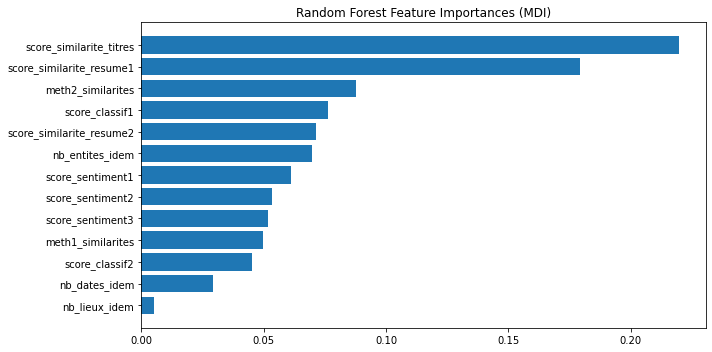

In [135]:
import matplotlib
import matplotlib.pyplot as plt
tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(predicteurs))
fig, ax = plt.subplots(figsize = (10,5))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.array(predicteurs)[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [136]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain[:taille_train],ytrain[:taille_train])
res_lda = lda.predict(Xtrain[taille_train:])
res_final = pd.concat([res_rf[['Overall','RF']],pd.DataFrame(res_lda,columns = ['LDA'],index = range(taille_train,dernier_test))],axis=1)
res_final

,Overall,RF,LDA
500,1,1,1
501,4,4,4
502,4,4,4
503,4,3,4
504,4,4,4
...,...,...,...
3395,3,4,3
3396,4,4,4
3397,1,1,1
3398,1,2,2


In [137]:
from numpy import around
import numpy
np.set_printoptions(suppress=True)  # supprime notation exp
res_lda2 = around(lda.predict_proba(Xtrain[taille_train:])*100, decimals=2)
res_lda2

array([[99.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.28, 10.45, 89.27],
       [ 0.  ,  0.01,  1.82, 98.16],
       ...,
       [94.6 ,  5.37,  0.03,  0.  ],
       [22.98, 58.67, 15.21,  3.14],
       [98.63,  1.36,  0.  ,  0.  ]])

In [138]:
res_rf2 = around(rf.predict_proba(Xtrain[taille_train:])*100, decimals=2)
res_rf2

array([[82., 15.,  3.,  0.],
       [ 0.,  1.,  7., 92.],
       [ 0.,  0., 12., 88.],
       ...,
       [70., 22.,  4.,  4.],
       [20., 42., 33.,  5.],
       [71., 24.,  4.,  1.]])

**_Remarquer que la classification ne tient pas compte du fait que c'est ordonné en classement 1-2-3-4 : ce qui est TRES important (ex : ligne 55% de 1 - 43% de 4) !! : il faudrait donc faire ressortir un score avec les probas plutot !!!_**

In [139]:
# Nouveau programme basé sur les scores probas : si plus de 50% mettre catégorie obtenue sinon, faire la somme 1-2 et 3/4 
# et prendre le plus gros score puis regarder si ce sore > 65% alors à ce moment là prendre le plus gros de la catégorie 
# sinon prendre 2 ou 3
def choix_classes(score_prob):
    classe_finale = []
    for i in range(len(score_prob)):
        res = list(score_prob[i,:])
        max_res = max(res)
        if max_res > 50:
            classe_finale.append(res.index(max_res)+1)
        else:
            som1 = res[0]+res[1]
            som2 = res[2]+res[3]
            if som1 > som2:
                if som1 >= 65:
                    choix = 1 if res[0]>res[1] else 2
                else:
                    choix = 2
            else:
                if som2 >= 65:
                    choix = 4 if res[3]>res[2] else 3
                else:
                    choix = 3
            classe_finale.append(choix)
    return classe_finale

In [140]:
liste_rf = choix_classes(res_rf2)
liste_lda = choix_classes(res_lda2)
res_final = pd.concat([res_final,pd.DataFrame(liste_lda,columns = ['LDA_Prob'],index = range(taille_train,dernier_test)),
                       pd.DataFrame(liste_rf,columns = ['RF_Prob'],index = range(taille_train,dernier_test))],axis=1)

In [141]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(Xtrain[:taille_train],ytrain[:taille_train])
res_knn = knn.predict(Xtrain[taille_train:])
liste_knn = choix_classes(around(knn.predict_proba(Xtrain[taille_train:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_knn,columns = ['KNN'],index = range(taille_train,dernier_test)),
                      pd.DataFrame(liste_knn,columns = ['KNN_Prob'],index = range(taille_train,dernier_test))],axis=1)

In [142]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(Xtrain[:taille_train],ytrain[:taille_train])
res_logreg = logreg.predict(Xtrain[taille_train:])
liste_logreg = choix_classes(around(logreg.predict_proba(Xtrain[taille_train:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_logreg,columns = ['LOGR'],index = range(taille_train,dernier_test)),
                      pd.DataFrame(liste_knn,columns = ['LOGR_Prob'],index = range(taille_train,dernier_test))],axis=1)

In [143]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(Xtrain[:taille_train],ytrain[:taille_train])
res_ada = ada.predict(Xtrain[taille_train:])
liste_ada = choix_classes(around(ada.predict_proba(Xtrain[taille_train:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_knn,columns = ['ADA'],index = range(taille_train,dernier_test)),
                      pd.DataFrame(liste_knn,columns = ['ADA_Prob'],index = range(taille_train,dernier_test))],axis=1)
res_final = res_final [['Overall','RF','LDA','KNN','LOGR','ADA','RF_Prob','LDA_Prob','KNN_Prob','LOGR_Prob','ADA_Prob']]

In [144]:
confusion_matrix(res_final.Overall,res_final.RF)

array([[ 373,   92,    4,   12],
       [ 108,  295,   70,   34],
       [  16,   92,  239,  212],
       [   4,   56,   84, 1209]], dtype=int64)

In [145]:
confusion_matrix(res_final.Overall,res_final.RF_Prob)

array([[ 365,  102,    2,   12],
       [  98,  287,   96,   26],
       [  12,   78,  259,  210],
       [   4,   34,  108, 1207]], dtype=int64)

In [146]:
confusion_matrix(res_final.Overall,res_final.LDA)

array([[ 370,   81,   19,   11],
       [ 138,  229,   94,   46],
       [  15,  100,  167,  277],
       [  14,   39,   80, 1220]], dtype=int64)

In [147]:
confusion_matrix(res_final.Overall,res_final.LDA_Prob)

array([[ 370,   82,   18,   11],
       [ 138,  213,  112,   44],
       [  15,   87,  180,  277],
       [  14,   37,   82, 1220]], dtype=int64)

In [148]:
confusion_matrix(res_final.Overall,res_final.KNN)

array([[ 285,  102,   40,   54],
       [ 153,  148,   84,  122],
       [  87,  105,  131,  236],
       [  69,   74,  204, 1006]], dtype=int64)

In [149]:
confusion_matrix(res_final.Overall,res_final.KNN_Prob)

array([[148, 226,  70,  37],
       [ 81, 184, 141, 101],
       [ 40, 101, 189, 229],
       [ 31,  64, 282, 976]], dtype=int64)

In [150]:
confusion_matrix(res_final.Overall,res_final.LOGR)

array([[ 351,   89,   18,   23],
       [ 157,  184,  110,   56],
       [  26,  106,  150,  277],
       [  26,   38,  101, 1188]], dtype=int64)

In [151]:
# attention, ce n'est plus bon du tout ....
confusion_matrix(res_final.Overall,res_final.LOGR_Prob)

array([[148, 226,  70,  37],
       [ 81, 184, 141, 101],
       [ 40, 101, 189, 229],
       [ 31,  64, 282, 976]], dtype=int64)

In [152]:
confusion_matrix(res_final.Overall,res_final.ADA)

array([[ 285,  102,   40,   54],
       [ 153,  148,   84,  122],
       [  87,  105,  131,  236],
       [  69,   74,  204, 1006]], dtype=int64)

In [153]:
confusion_matrix(res_final.Overall,res_final.ADA_Prob)

array([[148, 226,  70,  37],
       [ 81, 184, 141, 101],
       [ 40, 101, 189, 229],
       [ 31,  64, 282, 976]], dtype=int64)

## REGRESSION Sklearn Pycaret

In [160]:
from pycaret.regression import *
from sklearn.linear_model import LinearRegression
anglais = pd.read_csv('corpus_en_notes.csv',index_col=0)
anglais = anglais.reset_index(drop=True)
anglais2 = pd.read_csv('corpus_en_de_notes.csv',index_col=0)
anglais2 = anglais.reset_index(drop=True)
# attention, il faut les memes colonnes
anglais2 = anglais[anglais.columns]
anglais = pd.concat([anglais,anglais2],axis=0).reset_index(drop=True)

In [165]:
anglais = anglais[anglais.meth1_similarites!='Error']

In [161]:
lr = create_model('lr')
rr = create_model('lasso')
etr = create_model('et')
svr = create_model('svm')
adar = create_model('ada')
mlpr = create_model('mlp')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.2279,17.7539,4.2135,-12.3815,0.7085,1.5291
1,4.5226,42.5755,6.5250,-37.9037,0.7880,1.8592
2,4.1452,28.4365,5.3326,-22.1416,0.7047,1.6180
3,2.8254,14.4516,3.8015,-10.5123,0.6264,1.2016
4,2.9235,42.6111,6.5277,-34.3677,0.6416,1.2376
5,3.2684,18.4333,4.2934,-15.3940,0.6389,1.3161
6,5.8391,99.0721,9.9535,-80.4637,0.9300,2.5391
7,5.3502,63.0546,7.9407,-51.9265,0.8439,2.1435
8,2.2868,8.3131,2.8833,-5.8671,0.5610,1.0157
9,2.7859,12.5460,3.5420,-10.2608,0.5891,1.0047


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5089,0.4207,0.6486,0.6829,0.2114,0.2872
1,0.4312,0.3105,0.5572,0.7163,0.1632,0.1920
2,0.3850,0.2474,0.4974,0.7987,0.1433,0.1695
3,0.3932,0.2348,0.4846,0.8130,0.1544,0.2005
4,0.5151,0.4658,0.6825,0.6134,0.2055,0.2413
5,0.4520,0.4445,0.6667,0.6047,0.2016,0.2327
6,0.4050,0.3247,0.5698,0.7330,0.1714,0.1875
7,0.4697,0.3694,0.6078,0.6899,0.1837,0.2264
8,0.3954,0.2564,0.5063,0.7882,0.1508,0.1809
9,0.4666,0.4100,0.6403,0.6320,0.1906,0.2255


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3591,0.2440,0.4939,0.8161,0.1598,0.1927
1,0.3809,0.3449,0.5873,0.6849,0.1730,0.1576
2,0.3125,0.2359,0.4857,0.8080,0.1432,0.1422
3,0.2979,0.1850,0.4301,0.8527,0.1303,0.1364
4,0.4811,0.5159,0.7182,0.5718,0.2121,0.2034
5,0.4045,0.4183,0.6468,0.6280,0.1875,0.1810
6,0.3338,0.3016,0.5492,0.7520,0.1620,0.1464
7,0.4282,0.3758,0.6131,0.6845,0.1755,0.1761
8,0.2947,0.2279,0.4774,0.8118,0.1354,0.1314
9,0.4279,0.4243,0.6514,0.6192,0.1994,0.1967


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4555,0.3809,0.6172,0.7129,0.2028,0.2637
1,0.3978,0.3103,0.5570,0.7165,0.1646,0.1791
2,0.3474,0.2276,0.4771,0.8148,0.1407,0.1542
3,0.3477,0.2155,0.4642,0.8284,0.1479,0.1773
4,0.4798,0.4635,0.6808,0.6153,0.2069,0.2241
5,0.4349,0.4295,0.6553,0.6181,0.2006,0.2291
6,0.3558,0.2568,0.5068,0.7888,0.1487,0.1649
7,0.4293,0.3503,0.5919,0.7060,0.1773,0.2030
8,0.3292,0.2156,0.4644,0.8219,0.1422,0.1592
9,0.4540,0.4323,0.6575,0.6120,0.1955,0.2198


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5784,0.4506,0.6712,0.6604,0.2119,0.3007
1,0.5569,0.4164,0.6453,0.6195,0.1816,0.2343
2,0.5523,0.3787,0.6154,0.6918,0.1741,0.2355
3,0.5240,0.3576,0.5980,0.7152,0.1828,0.2538
4,0.5938,0.5046,0.7103,0.5812,0.2057,0.2572
5,0.6110,0.5391,0.7342,0.5206,0.2122,0.2722
6,0.5941,0.4698,0.6854,0.6137,0.1946,0.2558
7,0.5593,0.4382,0.6619,0.6322,0.1929,0.2534
8,0.4611,0.3270,0.5718,0.7299,0.1660,0.2042
9,0.5390,0.4355,0.6599,0.6092,0.1933,0.2453


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5813,0.5220,0.7225,0.6065,0.2230,0.3037
1,0.4784,0.3978,0.6307,0.6365,0.1797,0.2040
2,0.4644,0.3462,0.5884,0.7182,0.1618,0.1874
3,0.4473,0.3223,0.5677,0.7433,0.1773,0.2290
4,0.6252,0.9349,0.9669,0.2240,0.2622,0.2745
5,0.5016,0.4754,0.6895,0.5772,0.2107,0.2436
6,0.4873,0.4155,0.6446,0.6584,0.1907,0.2244
7,0.5917,0.5569,0.7463,0.5325,0.2114,0.2497
8,0.4415,0.3161,0.5622,0.7389,0.1650,0.1989
9,0.5479,0.4987,0.7062,0.5524,0.2065,0.2523


In [166]:
# Linear Regression simple sur scikit learn
essai_classif = anglais[['Geography','Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone','nb_entites_idem', 
    'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1','score_similarite_resume2', 
    'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'score_sentiment3','meth1_similarites','meth2_similarites']]
lr = LinearRegression()
Xtrain = essai_classif[predicteurs].reset_index(drop=True)
ytrain = essai_classif['Overall'].reset_index(drop=True)

In [167]:
Xtrain = Xtrain.loc[np.where(Xtrain['score_classif1'].notnull())[0]].reset_index(drop=True)
ytrain = ytrain[(ytrain.index != 469) & (ytrain.index != 2170)].reset_index(drop=True)

In [168]:
lr.fit(Xtrain[:taille_train],ytrain[:taille_train])
res_lr = lr.predict(Xtrain[taille_train:])
res_lr = pd.concat([Xtrain[taille_train:],ytrain[taille_train:],pd.DataFrame(res_lr,columns = ['LR'],index = range(taille_train,dernier_test))],axis=1)
res_lr

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,score_sentiment3,meth1_similarites,meth2_similarites,Overall,LR
500,12,0,6,50.38,40.52,-1.43,11.16,8.37,28.23,84.30,99.21,836.8,955.1,1.0,0.612669
501,0,0,5,4.40,4.84,-3.35,6.38,8.40,21.31,39.07,64.69,406.8,505.5,4.0,3.711447
502,0,0,0,1.54,1.41,15.27,8.01,8.33,9.04,20.11,3.27,0,0,4.0,4.141353
503,10,0,0,12.28,14.97,5.67,10.96,8.33,21.39,8.42,95.43,722.7,314.2,4.0,3.131612
504,1,0,0,15.36,-0.60,1.09,9.68,8.32,22.96,24.46,91.60,141.8,270.2,4.0,3.505050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,0,0,0,15.18,0.96,-0.44,52.18,9.54,28.40,97.16,99.92,289.7,418.5,3.0,3.115016
3396,2,0,0,4.29,14.06,1.64,27.53,8.29,31.73,1.55,13.10,40.4,150.6,4.0,3.404905
3397,7,0,6,40.45,40.11,24.78,10.46,8.36,46.47,84.41,97.96,547.7,717.2,1.0,1.102186
3398,9,0,1,22.58,29.80,-0.50,10.97,8.42,19.91,1.06,93.64,1364.2,440.1,1.0,2.267368


In [169]:
res_final = pd.concat([res_final,res_lr['LR']],axis=1)

In [170]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression()
pls.fit(Xtrain[:taille_train],ytrain[:taille_train])
res_pls = list(pls.predict(Xtrain[taille_train:]).flatten())
res_pls = pd.concat([res_lr,pd.DataFrame(res_pls,columns = ['PLS'],index = range(taille_train,dernier_test))],axis=1)
res_pls

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,score_sentiment3,meth1_similarites,meth2_similarites,Overall,LR,PLS
500,12,0,6,50.38,40.52,-1.43,11.16,8.37,28.23,84.30,99.21,836.8,955.1,1.0,0.612669,0.937624
501,0,0,5,4.40,4.84,-3.35,6.38,8.40,21.31,39.07,64.69,406.8,505.5,4.0,3.711447,3.728716
502,0,0,0,1.54,1.41,15.27,8.01,8.33,9.04,20.11,3.27,0,0,4.0,4.141353,4.156205
503,10,0,0,12.28,14.97,5.67,10.96,8.33,21.39,8.42,95.43,722.7,314.2,4.0,3.131612,3.213291
504,1,0,0,15.36,-0.60,1.09,9.68,8.32,22.96,24.46,91.60,141.8,270.2,4.0,3.505050,3.609757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,0,0,0,15.18,0.96,-0.44,52.18,9.54,28.40,97.16,99.92,289.7,418.5,3.0,3.115016,2.596694
3396,2,0,0,4.29,14.06,1.64,27.53,8.29,31.73,1.55,13.10,40.4,150.6,4.0,3.404905,3.375768
3397,7,0,6,40.45,40.11,24.78,10.46,8.36,46.47,84.41,97.96,547.7,717.2,1.0,1.102186,1.170204
3398,9,0,1,22.58,29.80,-0.50,10.97,8.42,19.91,1.06,93.64,1364.2,440.1,1.0,2.267368,2.449016


In [171]:
res_final = pd.concat([res_final,res_pls['PLS']],axis=1)

In [172]:
res_final

,Overall,RF,LDA,KNN,LOGR,ADA,RF_Prob,LDA_Prob,KNN_Prob,LOGR_Prob,ADA_Prob,LR,PLS
500,1,1,1,1,1,1,1,1,1,1,1,0.612669,0.937624
501,4,4,4,2,4,2,4,4,3,3,3,3.711447,3.728716
502,4,4,4,4,4,4,4,4,4,4,4,4.141353,4.156205
503,4,3,4,2,3,2,3,4,3,3,3,3.131612,3.213291
504,4,4,4,4,4,4,4,4,4,4,4,3.505050,3.609757
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,3,4,3,3,4,3,4,3,3,3,3,3.115016,2.596694
3396,4,4,4,4,4,4,4,4,4,4,4,3.404905,3.375768
3397,1,1,1,2,1,2,1,1,2,2,2,1.102186,1.170204
3398,1,2,2,4,2,4,2,2,4,4,4,2.267368,2.449016


**Pour le classement final utiliser aussi la stade de base des notations : si plus de 4 ....** <br/>
**Pour le seuils : Le mieux est d'utiliser un algo qui regrade les erreurs des autres ... NB / LR**

In [173]:
# on ne garde finalement que LDA - RF et LR en classif et sans les probas qui changent peu finalement
def choix_final(df):
    res = pd.DataFrame(columns = ['Overall','Classif_value','Regression_value','Classif','Regression','Final','Final_aide'])
    for i in range(df.index[0],df.index[len(df)-1]):
        my_dic = {}
        my_dic['Overall'] = df.Overall[i]                   
        my_dic['Classif_value'] = round((df.RF[i] + df.LDA[i] + df.LOGR[i])/3,2)
        my_dic['Regression_value'] = round((df.LR[i] + df.PLS[i])/2,2)
        if my_dic['Classif_value'] < 1.7:
            my_dic['Classif'] = 1
        elif my_dic['Classif_value'] < 2.5:
            my_dic['Classif'] = 2
        elif my_dic['Classif_value'] < 3.25:
            my_dic['Classif'] = 3
        else:
            my_dic['Classif'] = 4
        if my_dic['Regression_value'] <= 1.6:
            my_dic['Regression'] = 1
        elif my_dic['Regression_value'] < 2.5:
            my_dic['Regression'] = 2
        elif my_dic['Regression_value'] < 3.5:
            my_dic['Regression'] = 3
        else:
            my_dic['Regression'] = 4
        diff = 0.01 if my_dic['Classif'] != my_dic['Regression'] else 0
        diff += 0.005 if abs(my_dic['Classif']-my_dic['Regression'])>=2 else 0
        my_dic['Final'] = round((my_dic['Classif']+my_dic['Regression'])/2,0)
        my_dic['Final_aide'] = round((my_dic['Classif']+my_dic['Regression'])/2,0)+diff
        res.loc[len(res)] = my_dic
        
    return res

In [174]:
vote = choix_final(res_final)
vote

,Overall,Classif_value,Regression_value,Classif,Regression,Final,Final_aide
0,1.0,1.00,0.78,1.0,1.0,1.0,1.00
1,4.0,4.00,3.72,4.0,4.0,4.0,4.00
2,4.0,4.00,4.15,4.0,4.0,4.0,4.00
3,4.0,3.33,3.17,4.0,3.0,4.0,4.01
4,4.0,4.00,3.56,4.0,4.0,4.0,4.00
...,...,...,...,...,...,...,...
2894,1.0,1.00,1.77,1.0,2.0,2.0,2.01
2895,3.0,3.67,2.86,4.0,3.0,4.0,4.01
2896,4.0,4.00,3.39,4.0,3.0,4.0,4.01
2897,1.0,1.00,1.14,1.0,1.0,1.0,1.00


In [175]:
#plutôt moins bon que la classif : peut etre question de seuil ...
confusion_matrix(vote.Overall,vote.Regression)

array([[280, 165,  25,  10],
       [ 71, 247, 178,  11],
       [  4,  77, 354, 124],
       [  4,  32, 350, 967]], dtype=int64)

In [176]:
# Ne sert à rien pratiquement, mais seuils à voir
confusion_matrix(vote.Overall,vote.Final)

array([[ 278,  177,   15,   10],
       [  64,  301,   91,   51],
       [   4,  113,  110,  332],
       [   4,   46,   46, 1257]], dtype=int64)

In [177]:
corr, _ = pearsonr(vote.Overall, vote.Final)
corr

0.8183695680938456

**REMARQUE GENERALE : IL Y A BCP DE 4 ce qui aide beaucoup pour la performance**